# Model diagnostics

This section prepare plots of model diagnostics, including [summary of the parameters predictions and Rhat values (ESM 8)](../outputs/ESM_8.csv), [MCMC chains (ESM 7)](../outputs/ESM_7.pdf), plots for posterior distribution for model parameters [](),  [counterfactual plots (figur 4)](../outputs/Fig2.tiff), as well as [posterior check of predicted vs observed values (ESM 10)](../outputs/ESM_10.pdf).

In [ ]:
### Load libraries
library(here) # setting paths
library(rstan) # for reading the modle
library(ggplot2) # for plots
library(bayesplot) #for special plots
library(grid) # For plotting with ggplot and grid
library(gridExtra)# to arrange graphs next to each other
library(ggridges) # For plotting probability density
library(matrixStats) # for geting quantiles

In [2]:
# Define paths:

# Inputs:

path2model<-here("outputs","models","parabolic_iCAR.rds") # Model
path2predictions <- here("outputs","05_01_Posterior_Predictions.csv") # Summary of the predictions for each county
path2stats<- here("outputs","03_01_Env_Mean_and_SD.csv") # Environmental variables summary
path2cfiles<-here("outputs") # Output files - to list fiels for counterfactual plots
path2env_table<-here("outputs","01_01_Predictor_variables.csv") # Path to full names of environmental variables:
path2prd_counties<-here("data","Prd_by_county.csv")

# Outputs

path2trace <- here("outputs","ESM_7.pdf")
path2model_summary<-here("outputs","ESM_8.csv")
path2posterior <- here("outputs","06_01_Parameters_posterior.tiff")
path2posterior_density <- here("outputs","06_02_Parameters_posterior_density.tiff")
path2pairs <- here("outputs","06_03_Pairs_plot.tiff")
path2cf_plots <-here("outputs","Fig2.tiff")
path2intervals<- here("outputs","ESM_10.pdf")

In [3]:
### Read data

# Load the model
fit<-readRDS(path2model)

# Get files with counterfactual predictions
cfiles<-list.files(path=path2cfiles,full.names=TRUE)
cfiles<-subset(cfiles,lapply(cfiles, grepl,pattern="Counterfactual_predictions")==TRUE)

# Load the mean and standard deviation to transform environmental predictor values back to the original ones
stats<-read.csv(path2stats,row.names=1) 

# Get the full names of environmental variables
env_table<-read.csv(path2env_table,row.names = 1)

# Get observed values
prd<-read.csv(path2prd_counties)

# Get predictions
predictions<-read.csv(path2predictions) 

In [4]:
### Extract posterior and define parameters for plots
posterior <- rstan::extract(fit)
# Get parameters from fit
parameters <- names(posterior)
# Get np_cp
np_cp <- nuts_params(fit)

## Model summary

In [5]:
### Get model estimates with Rhat values
model_summary<- summary(fit)
model_summary<-as.data.frame(model_summary$summary) # turn into data frame
head(model_summary) # Optionally show top of the model summary in jupyter
write.csv(model_summary, file=path2model_summary, row.names=TRUE) # write to a file

mean        se_mean     sd         2.5%       25%          50%        
alpha -7.79663258 0.007626978 0.21984354 -8.2314365 -7.943836524 -7.79457663
beta1  0.23215185 0.003013441 0.33550094 -0.4188404  0.005553551  0.23278571
beta2 -0.09313838 0.001339878 0.11501401 -0.3186747 -0.170673791 -0.09308874
beta3 -0.90626818 0.006031845 0.26690987 -1.4351900 -1.085077661 -0.90470954
beta4  0.03829718 0.001494522 0.08898307 -0.1355320 -0.021533762  0.03848178
beta5 -0.62943276 0.008259078 0.43858714 -1.4927740 -0.925154109 -0.63052980
      75%         97.5%      n_eff      Rhat     
alpha -7.64578242 -7.3748523   830.8496 1.0204980
beta1  0.45595405  0.8934728 12395.4474 0.9999665
beta2 -0.01564998  0.1313423  7368.3678 0.9999380
beta3 -0.72627601 -0.3880363  1958.0734 1.0046473
beta4  0.09788562  0.2140551  3544.9488 1.0001608
beta5 -0.33213964  0.2267246  2819.9972 1.0030372

## MCMC traceplot

No divergences to plot.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



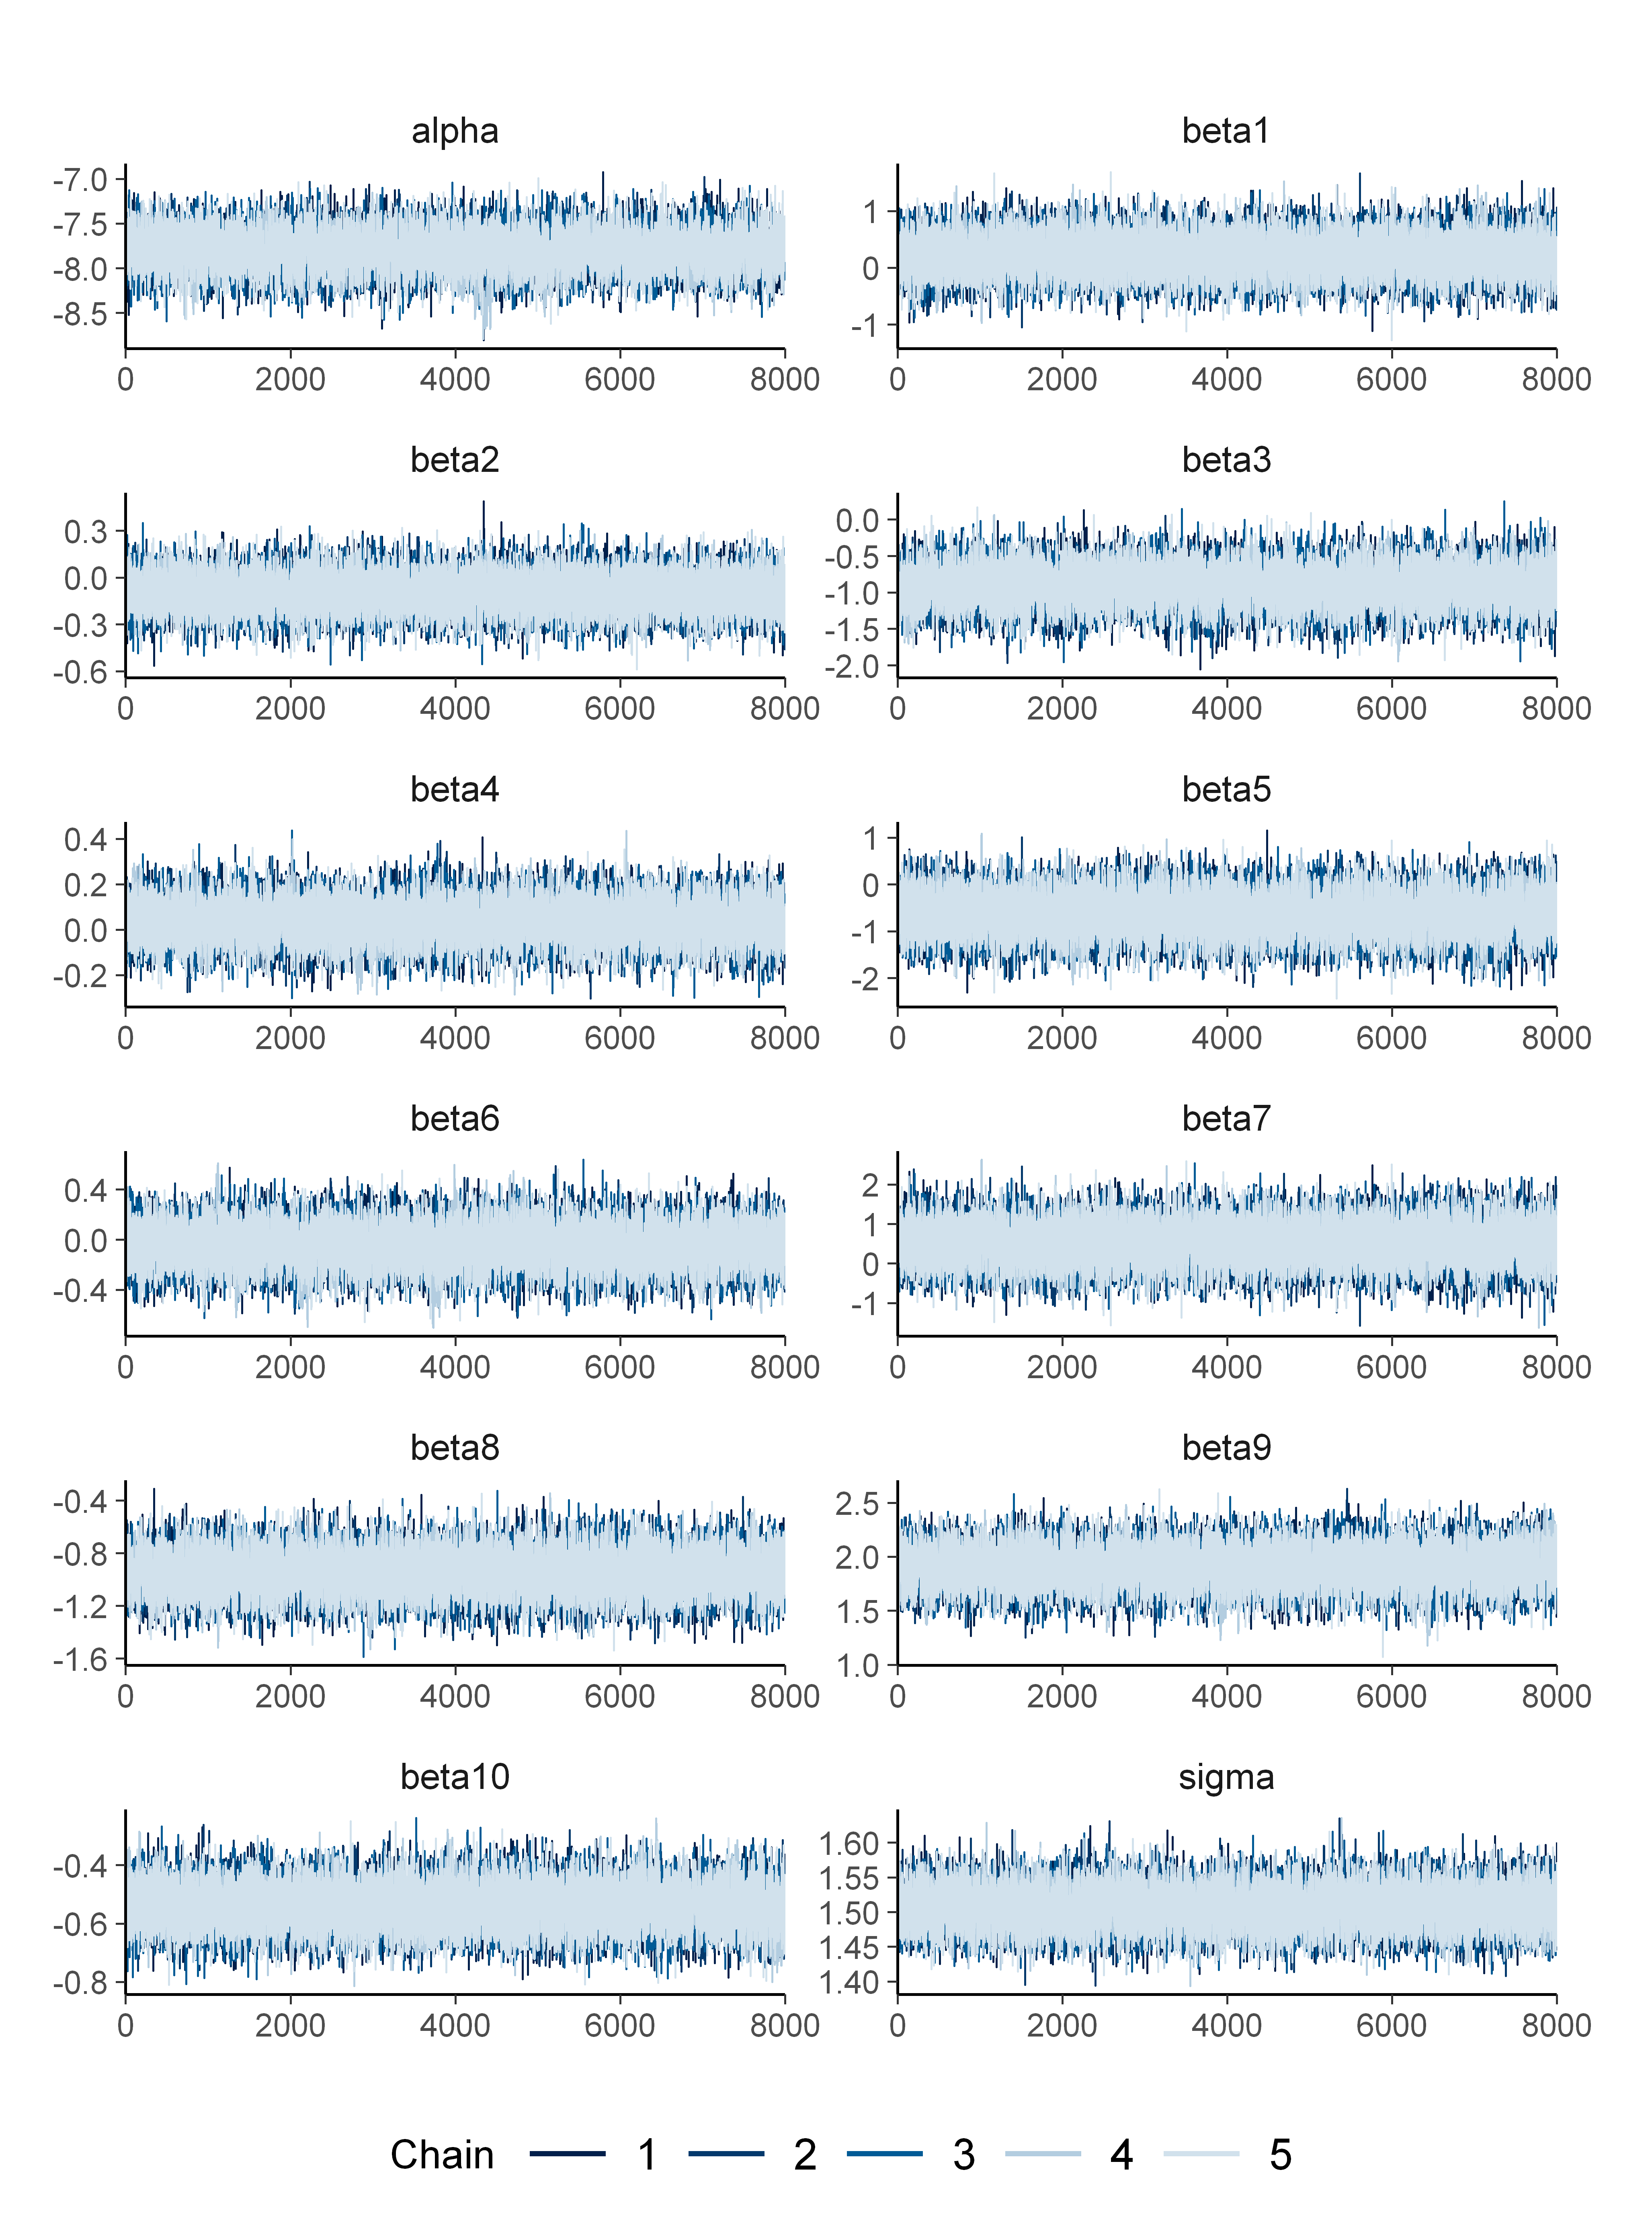

In [8]:
options(repr.plot.width=6.85,repr.plot.height=6.85,repr.plot.res=250)

### Plot MCMC chains

# Set colour scheme
color_scheme_set("blue")
# Plot the chains
traceplot<-mcmc_trace(fit, #number of warmup iterations to include
           regex_pars = c("alpha","beta","sigma"), #which parameters to show
           np = np_cp,
           facet_args=list(ncol=2)) + #options for how many plots to show per row
  theme(plot.margin = unit(c(1,1,0,0.5), "cm"),plot.title = element_text(hjust = 0.5),
       text = element_text(family = "sans"),panel.spacing = unit(0.5, "lines"),
       legend.key.size=(unit(1,"cm"))) + # defines the elements of the theme
  legend_move(position = "bottom")+ # moves legend to the bottom
  facet_text(family = "sans") + #defines the font of the text
  guides(color = guide_legend(override.aes = list(size = 0.75)))+ #override the legend size
  scale_x_continuous(limits = c(0,fit@stan_args[[1]]$iter-fit@stan_args[[1]]$warmup), expand = c(0, 0)) # zoom in on the limits of the x axis


# Optional: also show the plot in jupyter notebook
options(repr.plot.width=6.85,repr.plot.height=9.21,repr.plot.res=600)
traceplot

In [9]:
# Save the plot to a file
width =6.85
height = 9.21
ggsave(path2trace,traceplot,width = width, height = height)

## Plot parameters

In [12]:
### Plot parameter values

color_scheme_set("brightblue") # Set colour scheme

# Prepare plot
posterior_plot<-mcmc_intervals(fit,regex_pars = c("alpha","beta","sigma")) +
theme(text = element_text(family = "sans"), # defines the font of the text
      axis.text=element_text(size=6),# defines the size of the axis labels
      panel.grid.major.y=element_line(color="lightgray",size=0.1),
      plot.margin = unit(c(0.5,1,0.5,0.5), "cm"),plot.title = element_text(hjust = 0.5,size=12))


# Transform ggplot to grid table, to change the size of the data points
posterior_plot <- ggplot_build(posterior_plot) # Builds the qtable from posterior plot
posterior_plot$data[[3]]$size <- rep(1,length(posterior_plot$data[[3]]$size)) # This define the size of the quartile markers
posterior_plot$data[[4]]$size <- rep(2,length(posterior_plot$data[[4]]$size)) # This defines the size of the median points
posterior_plot <- ggplot_gtable(posterior_plot)

In [14]:
width = 8.4
height= 6.3
ggsave(path2posterior,posterior_plot,width = width, height = height, units = "cm", device='tiff',dpi=600)

In [ ]:
### Also plot the probability density for the parameters
posterior_density<-mcmc_areas(fit,regex_pars = c("alpha","beta","sigma"),point_est ="none") +
theme(text = element_text(family = "sans"), # defines the font of the text
      axis.text=element_text(size=6),# defines the size of the axis labels
      panel.grid.major.y=element_line(color="lightgray",size=0.1),
      plot.margin = unit(c(0.5,1,0.5,0.5), "cm"),plot.title = element_text(hjust = 0.5,size=12))+
      scale_y_discrete(expand = c(0.02, 0.02),limits = rev)+
      update_geom_defaults("ridgeline",list(size=0.1))+
      update_geom_defaults("segment",list(size=0.1))

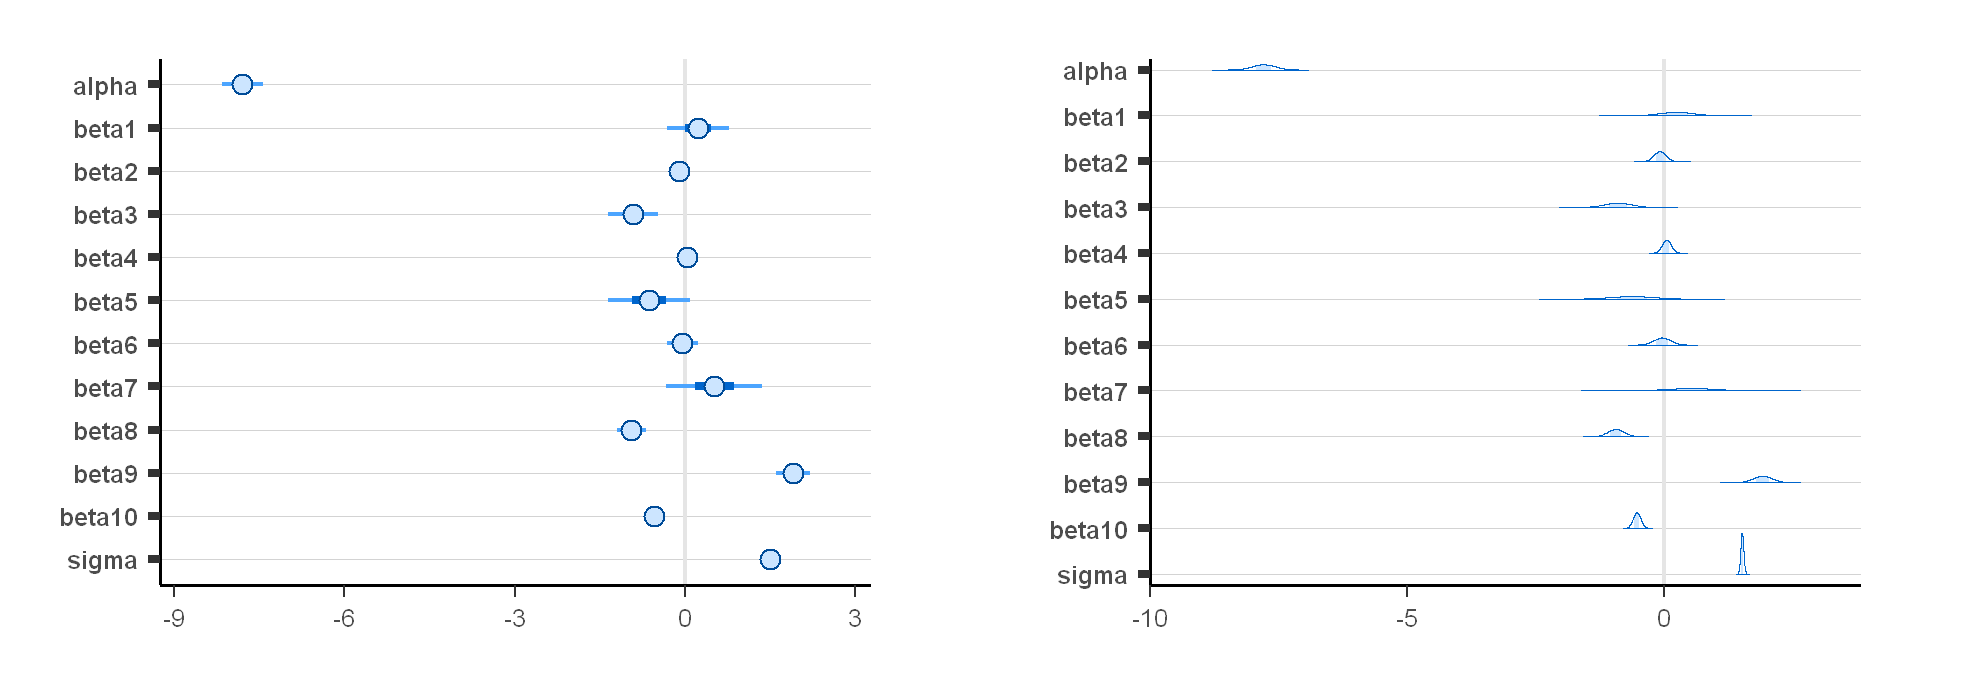

In [16]:
# Optional: plot in jupyter
options(repr.plot.width=6.6,repr.plot.height=2.3, repr.plot.res=300)
grid.arrange(posterior_plot,posterior_density,ncol=2)

In [17]:
width = 8.4
height= 6.3
ggsave(path2posterior_density,posterior_density,width = width, height = height, units = "cm", device='tiff',dpi=600)

In [18]:
# Parameters pairs plot
color_scheme_set("blue") # Change colour scheme
pairs<-mcmc_pairs(fit, regex_pars = c("alpha","beta","sigma"),off_diag_args = list(size = 0.001),diag_fun="dens") # Plot pairs

In [123]:
# Optional: plot in jupyter
options(repr.plot.width=6.25*4,repr.plot.height=6.25*4, repr.plot.res=300)
pairs

In [129]:
width = 17.4
height= 17.4
ggsave(path2pairs,pairs,width = width, height = height, units = "cm",device='tiff',dpi=600,scale=4)

## Counterfactual plots

In [19]:
### Load all the prediction data required for the counterfactual plots and define the ranges, based on information from stats

counterfactual_data<-c()
for(i in 1:length(cfiles)){
cpredictions<-read.csv(cfiles[i])
    y<-as.numeric(colMeans(cpredictions)) # Get mean predictions for each value of the predictor
    yquant<-data.frame(colQuantiles(as.matrix(cpredictions),probs = c(0.05,0.25,0.75,0.95))) # Get quantile for each value of the predictor
    yquant$mean<-y # combine data
    yquant$value<-seq(from = stats[i,'low_range'], to = stats[i,'high_range'],length.out=1000)
    if(rownames(stats)[i]=="BIO4 Temperature Seasonality"){
      yquant$value<-yquant$value/100
    }
    yquant$name<-rownames(stats)[i]
      
counterfactual_data[[i]]<-yquant
}

In [20]:
### Define labels and range for the plot
names<-env_table[rownames(stats),] # panel names
units <- c("°C","mm","°C","°C"," mass of carbon per unit area per year") # units
yrange<-c(-15,10) # predictions range

In [21]:
### Prepare plots for all variables
p1 <- ggplot(counterfactual_data[[1]], aes(value))+
geom_ribbon(aes(ymin=exp(X5.), ymax=exp(X95.)),fill="#cce5ff" )+
geom_ribbon(aes(ymin=exp(X25.), ymax=exp(X75.)),fill="#99cbff" )+
geom_line(aes(y=exp(mean)),col="#004c99")+
scale_y_continuous("",expand=c(0,0),limits=exp(yrange),trans='log10')+
scale_x_continuous(units[1],expand=c(0,0))+
ggtitle(names[1])+
theme_classic()+
theme(title=element_text(size=8))
p2 <- ggplot(counterfactual_data[[2]], aes(value))+
geom_ribbon(aes(ymin=exp(X5.), ymax=exp(X95.)),fill="#cce5ff" )+
geom_ribbon(aes(ymin=exp(X25.), ymax=exp(X75.)),fill="#99cbff" )+
geom_line(aes(y=exp(mean)),col="#004c99")+
scale_y_continuous("",expand=c(0,0),limits=exp(yrange),trans='log10')+
scale_x_continuous(units[2],expand=c(0,0))+
ggtitle(names[2])+
theme_classic()+
theme(title=element_text(size=8))
p3 <- ggplot(counterfactual_data[[3]], aes(value))+
geom_ribbon(aes(ymin=exp(X5.), ymax=exp(X95.)),fill="#cce5ff" )+
geom_ribbon(aes(ymin=exp(X25.), ymax=exp(X75.)),fill="#99cbff" )+
geom_line(aes(y=exp(mean)),col="#004c99")+
scale_y_continuous("Predicted suitability (area under cultivation)",expand=c(0,0),limits=exp(yrange),trans='log10')+
scale_x_continuous(units[3],expand=c(0,0))+
ggtitle(names[3])+
theme_classic()+
theme(axis.title=element_text(size=7),
     title=element_text(size=8))
p4 <- ggplot(counterfactual_data[[4]], aes(value))+
geom_ribbon(aes(ymin=exp(X5.), ymax=exp(X95.)),fill="#cce5ff" )+
geom_ribbon(aes(ymin=exp(X25.), ymax=exp(X75.)),fill="#99cbff" )+
geom_line(aes(y=exp(mean)),col="#004c99")+
scale_y_continuous("",expand=c(0,0),limits=exp(yrange),trans='log10')+
scale_x_continuous(units[4],expand=c(0,0))+
ggtitle(names[4])+
theme_classic()+
theme(title=element_text(size=8))
p5 <- ggplot(counterfactual_data[[5]], aes(value))+
geom_ribbon(aes(ymin=exp(X5.), ymax=exp(X95.)),fill="#cce5ff" )+
geom_ribbon(aes(ymin=exp(X25.), ymax=exp(X75.)),fill="#99cbff" )+
geom_line(aes(y=exp(mean)),col="#004c99")+
scale_y_continuous("",expand=c(0,0),limits=exp(yrange),trans='log10')+
scale_x_continuous(units[5],expand=c(0,0))+
ggtitle(names[5])+
theme_classic()+
theme(title=element_text(size=8))

# Prepare legend
p6<- ggplot(counterfactual_data[[1]], aes(value))+
geom_ribbon(aes(ymin=exp(X5.), ymax=exp(X95.),fill="95% confidence interval"))+
geom_ribbon(aes(ymin=exp(X25.), ymax=exp(X75.),fill="50% confidence interval" ))+
scale_fill_manual(values=c("#cce5ff","#99cbff"),name="")+
geom_line(aes(y=exp(mean),col="Mean predictions"))+
scale_colour_manual(values=c("#004c99"),name="")+
theme_classic()

legend <- cowplot::get_legend(p6)

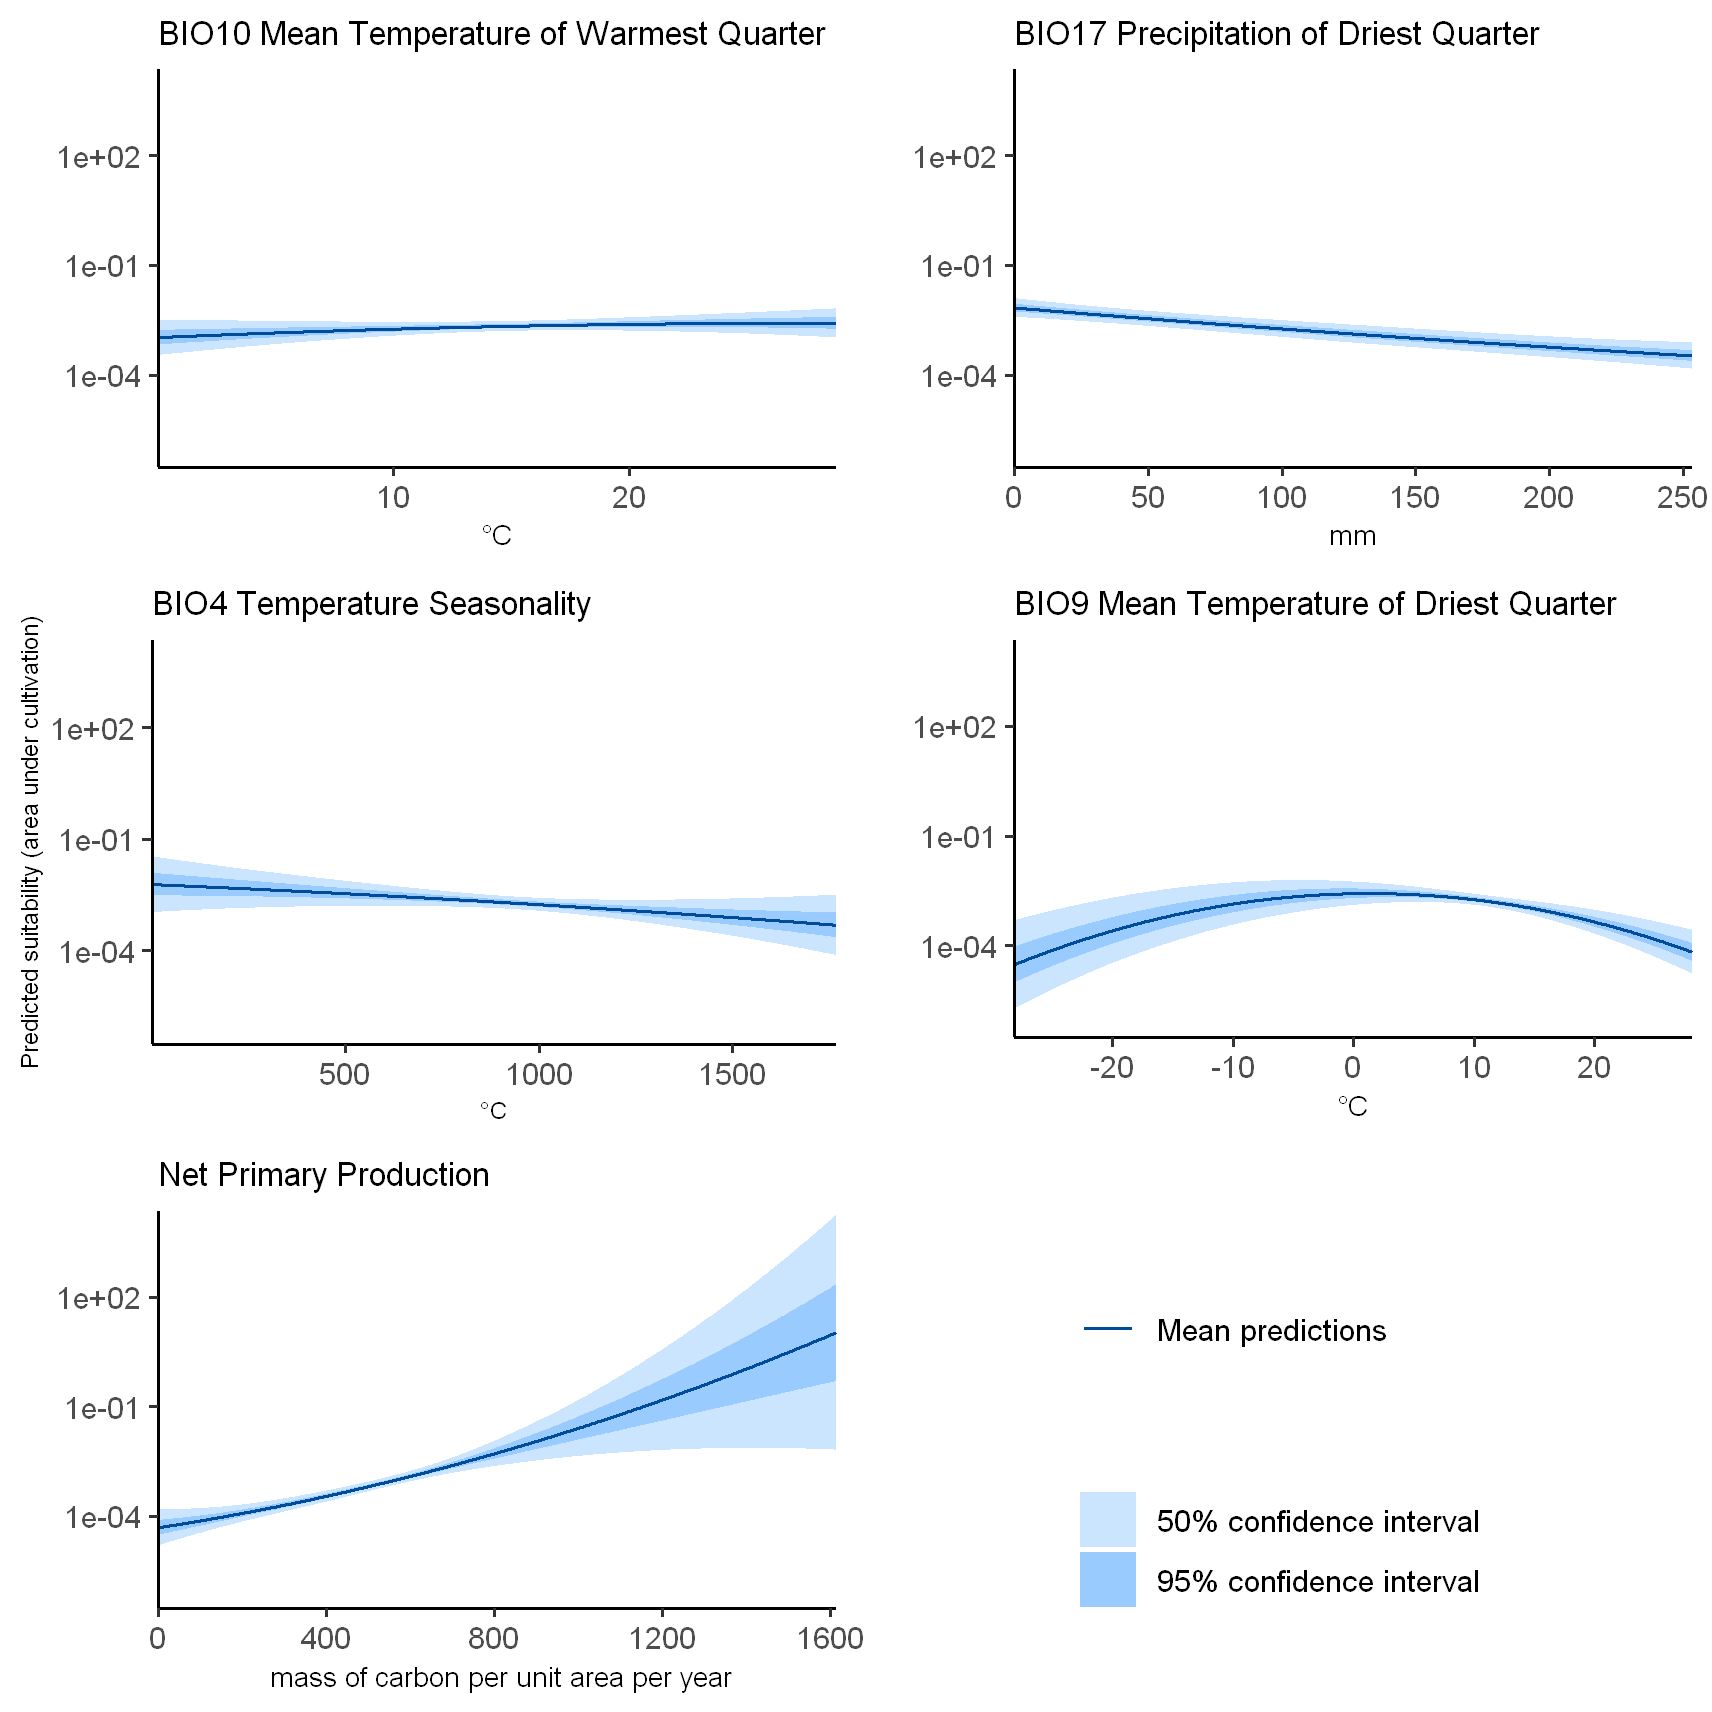

In [23]:
# Arrange grid and optionally plot in jupyter
options(repr.plot.width=6.85,repr.plot.height=6.85,repr.plot.res=250)
cfp<-grid.arrange(p1, p2, p3,p4,p5,legend, ncol=2)

In [24]:
### Save plot
height=20.4
width=17.4
ggsave(path2cf_plots,cfp,width = width, height = height,unit="cm",device="tiff",dpi=600)

## Plotting predictions check

In [25]:
#An S by N matrix of draws from the posterior predictive distribution, where S is the size of the posterior sample (or subset of the posterior sample used to generate yrep) and N is the number of observations (the length of y). The columns of yrep should be in the same order as the data points in y for the plots to make sense. See Details for additional instructions.
y=prd$logArea
yrep=as.matrix(predictions[order(y)])
y=y[order(y)]

In [ ]:
# Plot observed values over predictions intervals
intervals<-ppc_intervals(exp(y),exp(yrep), prob = 0.5, prob_outer = 0.95,size = 0.5, fatten = 3)+
    scale_x_continuous("county",breaks=NULL,labels=NULL,expand=c(0,0))+
    scale_y_continuous(trans="log10","\narea fraction under buckwheat cultivation")+
    theme_classic()+
    theme(axis.text.y=element_text( size=21, angle=0))+
    bayesplot:::scale_color_ppc_dist(labels = c("Observed", "Predicted")) + 
    bayesplot:::scale_fill_ppc_dist(labels = c("Observed", "Predicted"))+
    coord_flip()

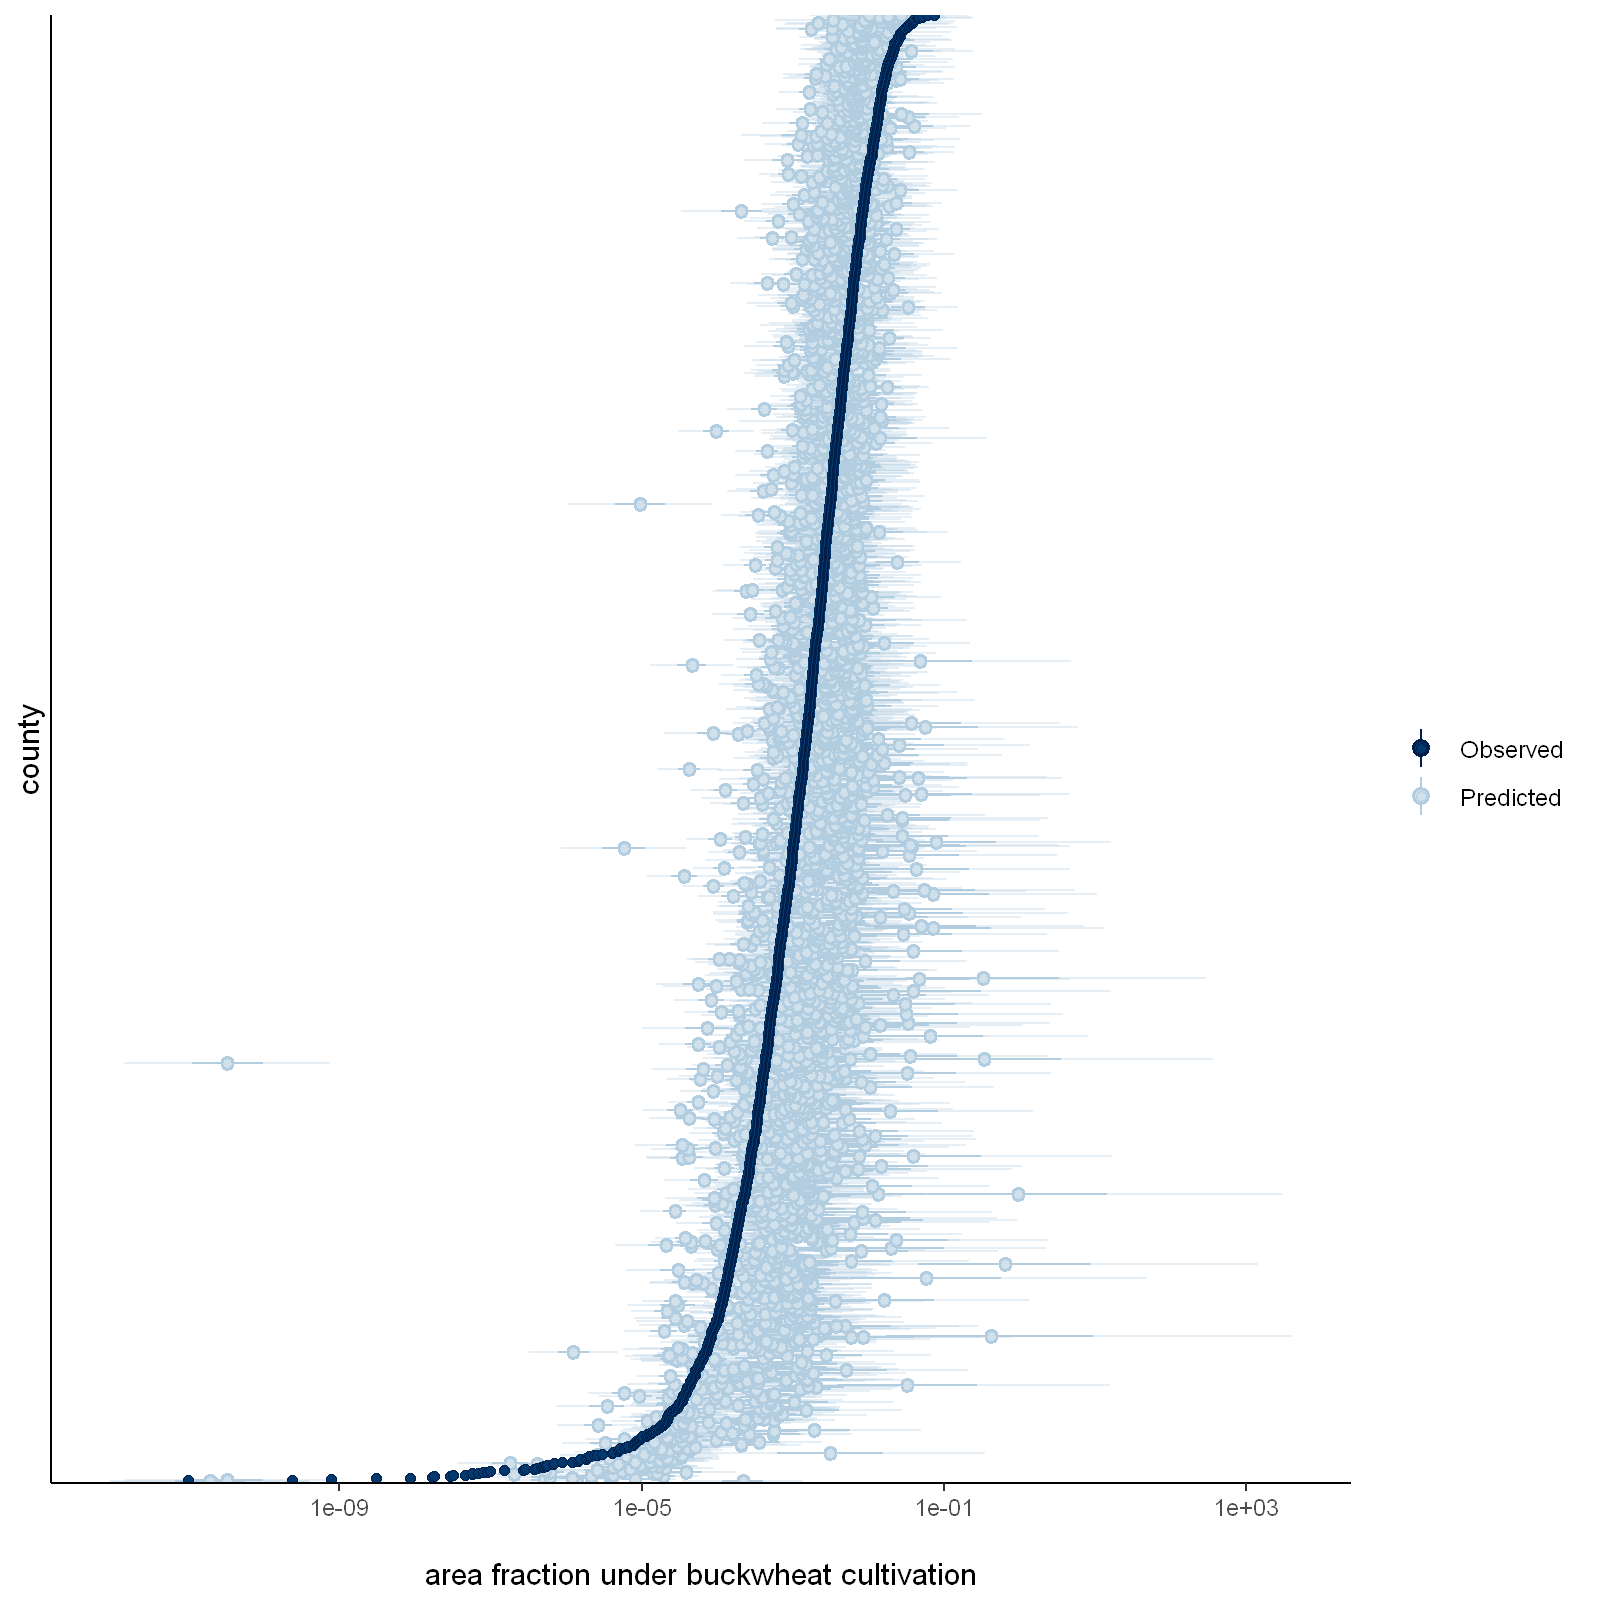

In [266]:
# Optionally plot in jupyter
intervals

In [18]:
# Save plot
width=17.4
height=23.4
ggsave(path2intervals,intervals,width = width, height = height,unit="cm")